# Dataset generation

## NER model

In [2]:
import copy

In [3]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)

[{'entity': 'B-PER', 'score': 0.99901396, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


In [4]:
def generate_decoder_input(example):
    output = copy.deepcopy(example)
    for i in range(len(output)):
        output[i] = "<s>" + output[i]
    
    return output
    

In [5]:
def generate_input(example):
    ner_results = nlp(example)
    output = copy.deepcopy(example)
    for i in range(len(output)):
        for entity in ner_results[i]:
            output[i] = output[i].replace(entity["word"], "<mask>", 1)
        output[i]+="</s>"
    
    return output

In [6]:
def generate_labels(example):
    output = copy.deepcopy(example)
    for i in range(len(output)):
        output[i]+="</s>"
    
    return output

In [7]:
generate_input(["My name is Wolfgang and I live in Berlin","My job is eating cabbages in Nokia, Finland"])

['My name is <mask> and I live in <mask></s>',
 'My job is eating cabbages in <mask>, <mask></s>']

In [8]:
generate_decoder_input(["My name is Wolfgang and I live in Berlin","My job is eating cabbages in Nokia, Finland"])

['<s>My name is Wolfgang and I live in Berlin',
 '<s>My job is eating cabbages in Nokia, Finland']

In [9]:
generate_labels(["My name is Wolfgang and I live in Berlin","My job is eating cabbages in Nokia, Finland"])

['My name is Wolfgang and I live in Berlin</s>',
 'My job is eating cabbages in Nokia, Finland</s>']

# Pretraining

In [10]:
from tqdm import tqdm


In [11]:
example = ["My name is Wolfgang and I live in Berlin","My job is eating cabbages in Nokia, Finland"]

In [12]:
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

tok = BartTokenizer.from_pretrained("facebook/bart-large")
model = BartForConditionalGeneration(BartConfig())

input_batch = generate_input(example)
decoder_input_batch = generate_decoder_input(example)
labels_batch = generate_labels(example)

input_ids = tok.batch_encode_plus(input_batch, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
decoder_input_ids = tok.batch_encode_plus(decoder_input_batch, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
labels = tok.batch_encode_plus(labels_batch, add_special_tokens=False, return_tensors="pt", padding=True).input_ids

for i in tqdm(range(15)):
    loss = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, labels=labels)[0]
    print(loss)
    

 13%|█▎        | 2/15 [00:00<00:01,  6.80it/s]

tensor(11.1142, grad_fn=<NllLossBackward>)
tensor(11.2557, grad_fn=<NllLossBackward>)


 27%|██▋       | 4/15 [00:00<00:01,  7.29it/s]

tensor(11.3071, grad_fn=<NllLossBackward>)
tensor(11.1004, grad_fn=<NllLossBackward>)


 40%|████      | 6/15 [00:00<00:01,  6.93it/s]

tensor(11.0524, grad_fn=<NllLossBackward>)
tensor(11.1593, grad_fn=<NllLossBackward>)


 53%|█████▎    | 8/15 [00:01<00:00,  7.26it/s]

tensor(11.1218, grad_fn=<NllLossBackward>)
tensor(11.0081, grad_fn=<NllLossBackward>)


 67%|██████▋   | 10/15 [00:01<00:00,  7.03it/s]

tensor(11.1948, grad_fn=<NllLossBackward>)
tensor(11.1993, grad_fn=<NllLossBackward>)


 80%|████████  | 12/15 [00:01<00:00,  7.62it/s]

tensor(11.1916, grad_fn=<NllLossBackward>)
tensor(11.2420, grad_fn=<NllLossBackward>)


 93%|█████████▎| 14/15 [00:01<00:00,  7.93it/s]

tensor(11.2037, grad_fn=<NllLossBackward>)
tensor(11.1553, grad_fn=<NllLossBackward>)


100%|██████████| 15/15 [00:02<00:00,  7.35it/s]

tensor(11.1550, grad_fn=<NllLossBackward>)


In [13]:
loss

tensor(11.1550, grad_fn=<NllLossBackward>)

### dataset handeling

In [14]:
from pathlib import Path

def read_imdb_split(split_dir):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["pos", "neg"]:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(0 if label_dir is "neg" else 1)

    return texts, labels

train_texts, train_labels = read_imdb_split('aclImdb/train')
test_texts, test_labels = read_imdb_split('aclImdb/test')

<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-14-1a25e9e1b27c>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  labels.append(0 if label_dir is "neg" else 1)


In [15]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

In [16]:
from transformers import BartTokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

In [17]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [18]:
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)


In [19]:
import apex

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

#model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
model = BartForConditionalGeneration(BartConfig())
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

In [ ]:
# from torch.utils.data import DataLoader
# from transformers import DistilBertForSequenceClassification, AdamW

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
# model.to(device)
# model.train()

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# optim = AdamW(model.parameters(), lr=5e-5)

# for epoch in range(3):
#     for batch in train_loader:
#         optim.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs[0]
#         loss.backward()
#         optim.step()

# model.eval()

# Summarization

In [1]:
!pip install transformers==4.8.2
!pip install datasets==1.10.0
!pip install rouge_score
!pip install nltk

# Imports

In [1]:
from transformers import (
    BartForConditionalGeneration,
    BartTokenizerFast,
    DataCollatorForSeq2Seq,
    AdamW,
    get_scheduler,
)

from datasets import (
    load_metric, 
    load_dataset,
    load_from_disk
)

from torch.utils.data import DataLoader

import torch
import nltk
import numpy as np
from matplotlib import pyplot as plt

nltk.download('punkt');

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Preparation of dataset

In [4]:
!pwd

/workspace


In [2]:
# Dataset parameters

batch_size = 2
max_source_length = 1024
max_target_length = 256
padding = 'max_length'

In [3]:
# Loading pretrained facebook/bart-base tokenizer

tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-base')

In [4]:
# Loading raw CNN/DailyMail dataset

raw_dataset = load_dataset('cnn_dailymail', '3.0.0')
column_names = raw_dataset['train'].column_names

raw_dataset

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [8]:
# Function for processing dataset for loading into a model

def process_data_to_model_inputs(example):
    inputs = example['article']
    targets = example['highlights']

    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, padding=padding, truncation=True)

    labels['input_ids'] = [[(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels['input_ids']]

    model_inputs['labels'] = labels['input_ids']
    
    return model_inputs

In [9]:
# Processing dataset, split on train, eval, test datasets

dataset = raw_dataset.map(
    process_data_to_model_inputs,
    batched = True,
    batch_size = batch_size,
    remove_columns = column_names,
    load_from_cache_file = True,
)

train_dataset = dataset['train']
eval_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset, eval_dataset, test_dataset

  0%|          | 0/4487 [00:00<?, ?ba/s]

  0%|          | 0/209 [00:00<?, ?ba/s]

  0%|          | 0/180 [00:00<?, ?ba/s]

(Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 287113
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 13368
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 11490
 }))

In [10]:
# Saving dataset to disk for later reuse

dataset.save_to_disk('content/processed_dataset')

In [5]:
# Loading dataset from disk for reuse

dataset = load_from_disk('content/processed_dataset')

train_dataset = dataset['train']
eval_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset, eval_dataset, test_dataset

(Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 287113
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 13368
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 11490
 }))

In [6]:
# Taking a part of the dataset for test training

dataset_part = 1

train_dataset = dataset['train'].select(range(len(dataset['train']) // dataset_part))
eval_dataset = dataset['validation'].select(range(len(dataset['validation']) // dataset_part))
test_dataset = dataset['test'].select(range(len(dataset['test']) // dataset_part))

train_subset = train_dataset.select(range(len(eval_dataset)))

train_dataset, train_subset, eval_dataset, test_dataset

(Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 287113
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 13368
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 13368
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 11490
 }))

# Preparation of model

In [7]:
# Loading pretrained facebook/bart-base model: BartForConditionalGeneration

model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [8]:
# DataLoaders for each dataset

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding=padding
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size
)

subset_dataloader = DataLoader(
    train_subset,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size
)

eval_dataloader = DataLoader(
    eval_dataset,
    collate_fn=data_collator,
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=data_collator,
    batch_size=batch_size
)

In [9]:
# Function for post-processing generated texts

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [10]:
torch.cuda.empty_cache()

In [11]:
!nvidia-smi

Wed Aug 11 17:33:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   52C    P0   237W / 300W |   9959MiB / 32478MiB |     83%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   47C    P0    53W / 300W |  16326MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [12]:
# Training parameters

epoch_num = 10
optimizer_steps = 128

base_learning_rate = 3e-4
betas = (0.9, 0.999)
eps = 1e-8
weight_decay = 0.01

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.01,
    },
    {
        'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0,
    },
]

num_warmup_steps = 256
num_training_steps = epoch_num * len(train_dataloader)
lr_scheduler_type = 'linear'

num_beams = 3

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [13]:
# Optimizer: AdamW

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=base_learning_rate,
    betas=betas,
    eps=eps,
)

In [14]:
# Lr_scheduler

lr_scheduler = get_scheduler(
    name=lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [15]:
# Metric

metric = load_metric('rouge')

In [16]:
# Transfer model to GPU

model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        

In [17]:
# Metrics

train_losses = []
train_losses_epoch = []
eval_losses_epoch = []
metrics = []

# Training

In [ ]:
# Training loop

completed_steps = 0

for epoch in range(epoch_num):
    train_loss_sum = 0
    eval_loss_sum = 0
    loss_buf = 0

    print('model training')
    model.train()

    for step, batch in enumerate(train_dataloader):
        completed_steps += 1

        batch = batch.to(device)
        outputs = model(**batch)
        loss = outputs.loss
        
        loss_buf += loss.item()
        train_losses.append(loss.item())
        loss.backward()

        if step % optimizer_steps == 0 or step == len(train_dataset) - 1:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            print(f'opimizers updated, step {completed_steps} / {epoch_num * len(train_dataloader)}, loss {loss_buf}')
            loss_buf = 0

    print('model evaluating')
    model.eval()

    gen_kwargs = {
        'max_length': 256,
        'num_beams': 3
    }

    for step, batch in enumerate(eval_dataloader):
        batch = batch.to(device)
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            
            eval_loss_sum += loss.item()

            generated_tokens = model.generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                **gen_kwargs,
            )

            labels = batch["labels"]

            labels = labels.cpu().numpy()
            generated_tokens = generated_tokens.cpu().numpy()

            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

            metric.add_batch(predictions=decoded_preds, references=decoded_labels)
    
    eval_result = metric.compute(use_stemmer=True)
    metrics.append(eval_result)
    result = {key: round(value.mid.fmeasure * 100, 4) for key, value in eval_result.items()}

    for step, batch in enumerate(subset_dataloader):
        batch = batch.to(device)
        outputs = model(**batch)
        loss = outputs.loss

        train_loss_sum += loss.item()

    train_losses_epoch.append(train_loss_sum)
    eval_losses_epoch.append(eval_loss_sum)

    print(f'evaluating metrics: {result}')
    print(f'epoch {epoch + 1} / {epoch_num} completed, train_loss: {train_loss_sum}, eval loss: {eval_loss_sum}')

print('training completed')

model training
opimizers updated, step 1 / 1435570, loss 4.326367378234863
opimizers updated, step 129 / 1435570, loss 569.5679888725281
opimizers updated, step 257 / 1435570, loss 549.0737895965576
opimizers updated, step 385 / 1435570, loss 544.4964938163757
opimizers updated, step 513 / 1435570, loss 523.524290561676
opimizers updated, step 641 / 1435570, loss 516.6678054332733
opimizers updated, step 769 / 1435570, loss 504.1267936229706
opimizers updated, step 897 / 1435570, loss 480.6759955883026
opimizers updated, step 1025 / 1435570, loss 485.59634804725647
opimizers updated, step 1153 / 1435570, loss 475.6121323108673
opimizers updated, step 1281 / 1435570, loss 458.60372829437256
opimizers updated, step 1409 / 1435570, loss 439.793946146965
opimizers updated, step 1537 / 1435570, loss 435.33740639686584
opimizers updated, step 1665 / 1435570, loss 415.49433290958405
opimizers updated, step 1793 / 1435570, loss 418.0387616157532
opimizers updated, step 1921 / 1435570, loss 409

In [ ]:
# Saving model to disk for later reuse

torch.save(model, 'content/model/model.zip')

In [11]:
# Loading model from disk for reuse

model = torch.load('content/model/model.zip')

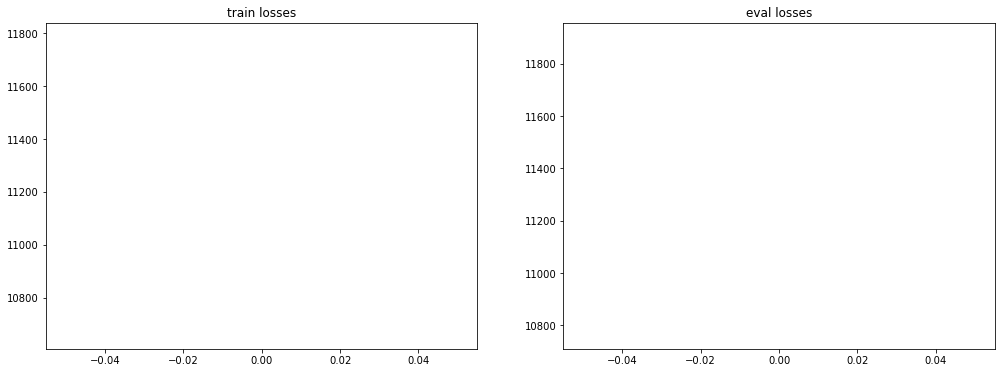

In [19]:
# Training and evaluation losses by epoch

fig, ax = plt.subplots(1, 2, figsize=(17,6))

ax[0].plot(train_losses_epoch)
ax[0].set_title('train losses')
ax[1].plot(eval_losses_epoch)
ax[1].set_title('eval losses');

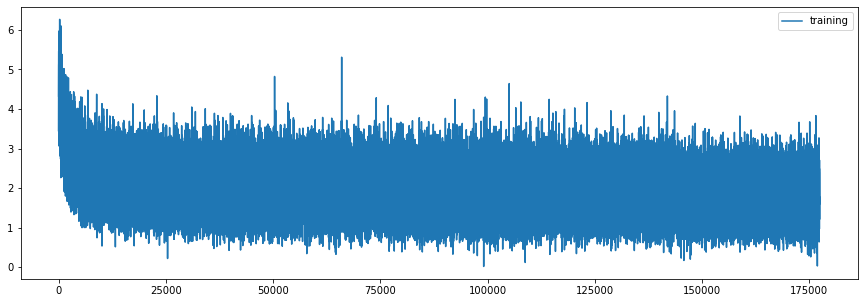

In [20]:
# Training loss graphic

plt.figure(figsize=(15,5))
plt.plot(train_losses)
plt.legend(['training'])
plt.show()

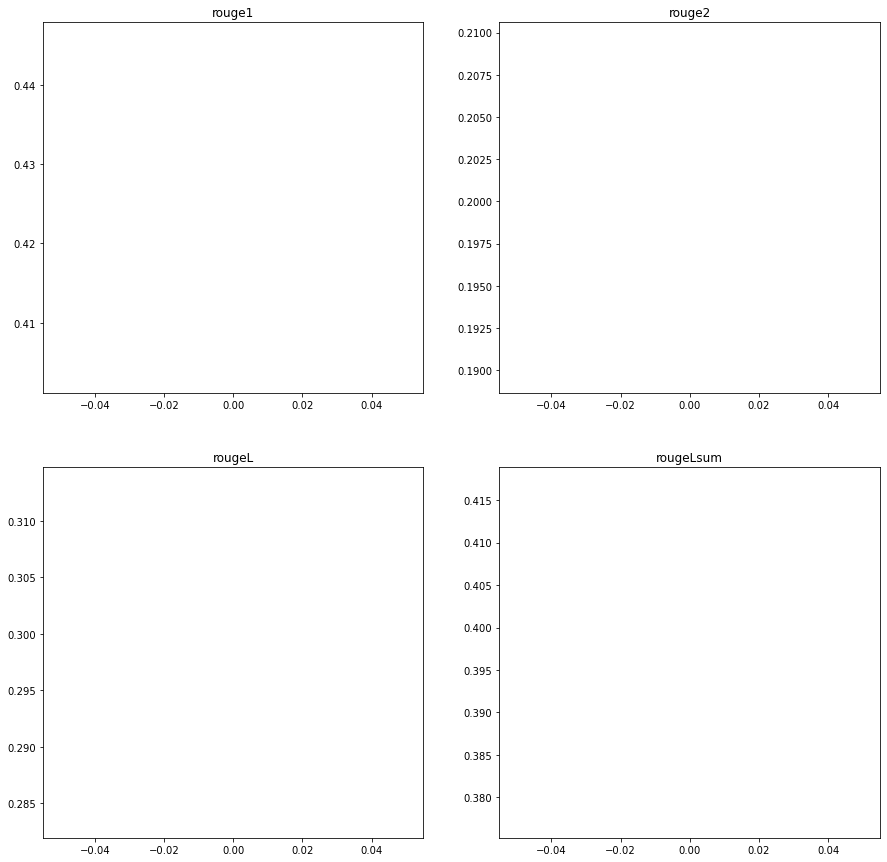

In [21]:
# Metric graphics

rouge1 = []
rouge2 = []
rougeL = []
rougeLsum = []

for metric_i in metrics:
    metric = {key: value.mid.fmeasure for key, value in metric_i.items()}
    rouge1.append(metric['rouge1'])
    rouge2.append(metric['rouge2'])
    rougeL.append(metric['rougeL'])
    rougeLsum.append(metric['rougeLsum'])

fig, ax = plt.subplots(2, 2, figsize=(15,15))

ax[0][0].plot(rouge1)
ax[0][0].set_title('rouge1')

ax[0][1].plot(rouge2)
ax[0][1].set_title('rouge2')

ax[1][0].plot(rougeL)
ax[1][0].set_title('rougeL')

ax[1][1].plot(rougeLsum)
ax[1][1].set_title('rougeLsum');

In [22]:
some_summaries = []

In [29]:
print('testing model')

gen_kwargs = {
    'max_length': 256,
    'num_beams': 3
}

for step, batch in enumerate(test_dataloader):
    batch = batch.to(device)
    with torch.no_grad():
        generated_tokens = model.generate(
            batch['input_ids'],
            attention_mask = batch['attention_mask'],
            **gen_kwargs                         
        )

        labels = batch['labels']

        labels = labels.cpu().numpy()
        generated_tokens = generated_tokens.cpu().numpy()

        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

        if step == 0 or step == 50 or step == 60 or step == 74:
            some_summaries.append((decoded_preds, decoded_labels))
            
        metric.add_batch(predictions=decoded_preds, references=decoded_labels)

        print(f'step {step + 1} / {len(test_dataloader)} completed')

test_result = metric.compute(use_stemmer=True)
result = {key: round(value.mid.fmeasure * 100, 4) for key, value in test_result.items()}

print(result)

testing model


AttributeError: 'dict' object has no attribute 'add_batch'

In [26]:
result

{'rouge1': 42.4506, 'rouge2': 19.9627, 'rougeL': 29.8358, 'rougeLsum': 39.7059}

In [30]:
for preds, labels in some_summaries:
    for pred, label in zip(preds, labels):
        print('pred')
        print(pred)
        print('label')
        print(label)
        print()
    

pred
James Best was best known for his role on "The Dukes of Hazzard"
He died in hospice in Hickory, North Carolina, of complications from pneumonia.
label
James Best, who played the sheriff on "The Dukes of Hazzard," died Monday at 88.
"Hazzard" ran from 1979 to 1985 and was among the most popular shows on TV.

pred
Dr. Anthony Moschetto, 54, pleads not guilty to all charges against him.
He is charged in what authorities say was a failed scheme to have another doctor hurt or killed.
Two other men are accused of being accomplices in the plot.
label
A lawyer for Dr. Anthony Moschetto says the charges against him are baseless.
Moschetto, 54, was arrested for selling drugs and weapons, prosecutors say.
Authorities allege Moschetto hired accomplices to burn down the practice of former associate.

pred
James Best was best known for his portrayal of bumbling sheriff Rosco P. Coltrane on "The Dukes of Hazzard"
Best died Monday after a brief illness.
label
James Best, who played the sheriff on

In [28]:
some_summaries

[(['James Best was best known for his role on "The Dukes of Hazzard"\nHe died in hospice in Hickory, North Carolina, of complications from pneumonia.',
   'Dr. Anthony Moschetto, 54, pleads not guilty to all charges against him.\nHe is charged in what authorities say was a failed scheme to have another doctor hurt or killed.\nTwo other men are accused of being accomplices in the plot.'],
  ['James Best, who played the sheriff on "The Dukes of Hazzard," died Monday at 88.\n"Hazzard" ran from 1979 to 1985 and was among the most popular shows on TV.',
   'A lawyer for Dr. Anthony Moschetto says the charges against him are baseless.\nMoschetto, 54, was arrested for selling drugs and weapons, prosecutors say.\nAuthorities allege Moschetto hired accomplices to burn down the practice of former associate.'])]